- In part 3, we selected the features – first by using VIF and p-values, and second by using domain knowledge
- Now we want to use these features to build a regression model while also including regularisation hyper parameter

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# load statmodels functions
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings 
warnings.filterwarnings('ignore')

<h5> Import data </h5>

In [115]:
df_daily = pd.read_csv('cleaned_data/df_daily.csv')

<h5> Drop irrelevant features </h5>

In [116]:
X = df_daily.drop('Unnamed: 0', axis = 1)
X = X.drop(['casual', 'registered', 'total', 'dew_point', 'year_month','app_temp_cat', 'date', 'calendar_week'], axis = 1)
y = df_daily['total']

# change datatype for "month" to string (in order to one-hot encode)
X['month'] = X['month'].apply(str)
X['year'] = X['year'].apply(str)

# one-hot encode the categorical variables
X_enc = pd.get_dummies(X, drop_first = True)

<h5> Select features </h5>

- In previous notebook, we settled on the following selection of features:
- 'year_2012', 'wind_speed', 'temp', 'humidity', 'season_spring', 'season_summer', 'season_winter', 'work_day_yes', 'weather_sit_clear', 'weather_sit_misty'

In [117]:
X_selection = X_enc[['year_2012', 'wind_speed','temp', 'humidity', 'season_spring', 'season_summer', 'season_winter', 'work_day_yes', 'weather_sit_clear', 'weather_sit_misty']]

<h5> Build ridge model with a range of regularisation parameters </h5>

In [132]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X_selection, y, test_size=0.3, random_state=45)

# Scale data

scaler = StandardScaler()
scaler.fit(X_train[['wind_speed', 'temp', 'humidity']])

X_train_scaled = X_train.copy(deep = True)
X_test_scaled = X_test.copy(deep = True)

# Scale continuous/numerical features
X_train_scaled [['wind_speed', 'temp', 'humidity']] = scaler.transform(X_train[['wind_speed', 'temp', 'humidity']])
X_test_scaled [['wind_speed', 'temp', 'humidity']] = scaler.transform(X_test [['wind_speed', 'temp', 'humidity']])



In [133]:
len(X_train_scaled), len(X_test_scaled)

(511, 220)

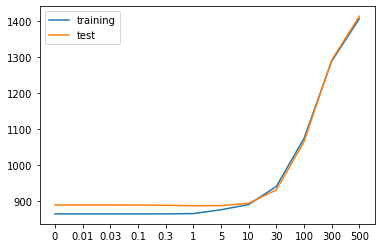

In [134]:
# Plot training error and cv error for a range of lambda values

alphas = [0, 0.01, 0.03, 0.1, 0.3, 1, 5, 10, 30, 100, 300, 500]
training_errors = []
test_errors = []
r2_scores = []
for alpha in alphas:
    ridge_model = Ridge(alpha = alpha)                      # create linear reg. model, specifying lambda

    ridge_model.fit(X_train_scaled, y_train)                # train lin. reg. model to get theta parameters

    y_pred_train = ridge_model.predict(X_train_scaled)      # use model to predict for training set
    y_pred_test = ridge_model.predict(X_test_scaled)        # use model to predict for test set

    MSE_train = mean_squared_error (y_pred_train, y_train)
    RMSE_train = np.sqrt(MSE_train)

    MSE_test = mean_squared_error (y_pred_test, y_test)
    RMSE_test = np.sqrt(MSE_test)

    training_errors.append(RMSE_train)
    test_errors.append(RMSE_test)

    r2_scores.append(r2_score(y_test, y_pred_test))
    r2_scores.append(r2_score(y_train, y_pred_train))

plt.plot(training_errors, label = 'training')
plt.plot(test_errors, label = 'test')
plt.xticks(ticks = range(len(alphas)), labels = alphas)
plt.legend()
plt.show()

- Why is there no peak for the test error in the low-bias region?
- Even when I make the test set be 90% of the data, there is no peak in test error in the low bias region...
- Only when I make the test set be 95% of the data do we get a slight incrase in test error in the low bias region.
- Does this just mean ... the y values are very evenly distributed? And no matter how we sample, we get a representative spread?
- When I make the test set be 99% of the data, then we get a huge jump in test error at bias = 0. But here, the training data has 7 entries, and test data has 724 entries
- This means, basically, as long as you have an even moderately sized training data set, you don't need regularisation.

- In short, there appears to be no need for regularisation. 
- There's enough noise in the data such that even with a relatively small training set, it's impossible to overfit the data with a straight line.

- Accuracy (train, test) with no regularisation:

In [135]:
100*(1 - training_errors[0]/(df_daily['total'].mean())), 100*(1- (test_errors[0]/(df_daily['total'].mean())))

(80.80236042500722, 80.24683762117465)

- R2 score with no regularisation:

In [136]:
r2_scores[0]

0.787082473687168